### Acq stats: comparing model to data and inferring results with MS filtering disabled

In [1]:
from __future__ import division

import sys

from pprint import pprint
from astropy.time import Time
from itertools import izip

import matplotlib.pyplot as plt
import tables
import numpy as np
from astropy.table import Table, join
%matplotlib inline

In [2]:
sys.path.insert(0, '/home/aldcroft/git/starcheck')
from starcheck import star_probs

In [3]:
tstart = Time('2014:001').cxcsec
filename = '/proj/sot/ska/data/acq_stats/acq_stats.h5'
with tables.openFile(filename) as h5:
    acq_stats = h5.root.data.readWhere('guide_tstart > {}'.format(tstart))
    acq_stats = Table(acq_stats)
acq_stats[:3]

obsid,obi,acq_start,guide_start,guide_tstart,one_shot_length,revision,slot,idx,type,yang,zang,halfw,mag,acqid,star_tracked,spoiler_tracked,img_func,n_trak_interv,max_trak_cdy,min_trak_cdy,mean_trak_cdy,max_trak_cdz,min_trak_cdz,mean_trak_cdz,max_trak_mag,min_trak_mag,mean_trak_mag,cdy,cdz,dy,dz,ion_rad,def_pix,mult_star,sat_pix,mag_obs,yang_obs,zang_obs,agasc_id,color1,ra,dec,epoch,pm_ra,pm_dec,var,pos_err,mag_aca,mag_err,mag_band,pos_catid,aspq1,aspq2,aspq3,acqq1,acqq2,acqq4,n100_warm_frac,ccd_temp,known_bad,bad_comment
int64,int64,string168,string168,float64,float64,string120,int64,int64,string40,float64,float64,int64,float64,bool,bool,bool,string56,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool,bool,bool,float64,float64,float64,int64,float64,float64,float64,float64,int64,int64,int64,int64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,bool,string120
53121,0,2014:001:01:18:28.685,2014:001:01:19:09.685,504926416.869,14.4032947731,1.0,0,1,BOT,-350.0,-92.0,120,8.057,True,True,False,star,1,0.862230552016,0.778150693951,0.827804283902,0.588106939909,0.514886800611,0.553465285968,8.125,8.125,8.125,0.778150693951,0.578296045783,-6.38303387603,-15.0257216855,False,False,False,False,8.125,-364.4,-100.55,445121504,0.0934997051954,109.32386637,48.46404128,2000.0,-13,-38,-9999,7,8.05727481842,1,4,5,0,0,999,-9999,586,373,0.132767511564,-16.0350036621,False,
53121,0,2014:001:01:18:28.685,2014:001:01:19:09.685,504926416.869,14.4032947731,1.0,1,2,BOT,-1490.0,842.0,120,8.069,True,True,False,star,1,0.559801976142,0.484686685104,0.523233158692,0.137851985605,0.0969262783726,0.116720296472,8.0625,8.0625,8.0625,0.484686685104,0.137851985605,-6.67684443381,-15.4669500247,False,False,False,False,8.0625,-1505.025,833.95,445121664,1.17810058594,109.66571602,48.12324311,2000.0,6,9,-9999,13,8.06908321381,1,4,5,0,0,999,528,460,271,0.132767511564,-16.0350036621,False,
53121,0,2014:001:01:18:28.685,2014:001:01:19:09.685,504926416.869,14.4032947731,1.0,2,3,BOT,-619.0,1666.0,120,9.261,True,True,False,star,1,0.163779796396,-0.0121490477923,0.0850837162932,0.276505003378,0.135589734185,0.22069175655,9.1875,9.1875,9.1875,0.0375586229869,0.152129139578,-7.12477668131,-15.4519421955,False,False,False,False,9.1875,-634.1,1658.7,445126720,1.11520028114,109.21979407,47.97435348,2000.0,-9999,-14,-9999,25,9.26143455505,2,4,5,0,0,999,-9999,236,236,0.132767511564,-16.0350036621,False,


In [4]:
acq_probs = star_probs.acq_success_prob(date=acq_stats['guide_tstart'],
                                    t_ccd=acq_stats['ccd_temp'], 
                                    mag=acq_stats['mag_aca'], 
                                    color=acq_stats['color1'])
acq_stats['acq_prob'] = acq_probs

In [5]:
def acqid_colname(without_ms):
    return 'acqid_no_MS' if without_ms else 'acqid'

In [6]:
probs = acq_stats.copy()  # for compatibility with previous convention in notebook

In [7]:
probs[acqid_colname(True)] = probs['acqid'] | ((probs['img_func'] == 'star') 
                                               & ~probs['ion_rad'] & ~probs['sat_pix'])

In [8]:
# Group by obsid for later
pg = probs.group_by('obsid')

In [9]:
def get_probs_groups_dict():
    return {grp['obsid'][0].tolist(): grp for grp in pg.groups}

In [10]:
def get_n_expected(without_ms=False):
    obsids = pg['obsid'].groups.aggregate(lambda x: x[0])
    n_expected = pg['acq_prob'].groups.aggregate(np.sum)
    n_acqs = pg[acqid_colname(without_ms)].groups.aggregate(np.sum)
    return n_acqs, n_expected, obsids

In [11]:
def get_n_or_fewer_expected(n_or_fewer, without_ms=False):
    lte_probs = []
    for i0, i1 in izip(pg.groups.indices[:-1], pg.groups.indices[1:]):
        n_acq_probs, n_or_fewer_probs = star_probs.prob_n_acq(pg['acq_prob'][i0:i1])
        lte_probs.append(n_or_fewer_probs[n_or_fewer])
    return np.array(lte_probs)

In [12]:
def plot_n_expected(n_acqs, n_expected):
    plt.clf()
    plt.plot(n_expected, n_acqs + np.random.uniform(-0.3, 0.3, size=len(n_acqs)), '.', alpha=0.3)
    plt.plot([0,8], [0,8], '--m')
    plt.ylim(-0.1, 8.5)
    plt.xlim(-0.1, 8.5)
    plt.grid()

In [13]:
def plot_acq_prob_vs_actual(data=probs, verbose=False, without_ms=False):
    bins = np.array([0, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0])
    p_actuals = []
    p_acq_probs = []
    for p0, p1 in zip(bins[:-1], bins[1:]):
        ok = (data['acq_prob'] >= p0) & (data['acq_prob'] < p1)
        n = np.sum(ok)
        if n > 10:
            pok = data[acqid_colname(without_ms)][ok]
            p_actuals.append(np.sum(pok) / n)
            pok = data['acq_prob'][ok]
            p_acq_probs.append(np.mean(pok))
            if verbose:
                print(p0, p1, len(pok))
    plt.clf()
    plt.plot(p_acq_probs, p_actuals, '.-')
    plt.grid()
    plt.plot([0, 1], [0, 1], '--r')
    plt.title('Actual vs predicted ACQ success{}'
              .format(' (without MS)' if without_ms else ''))
    plt.xlabel('Mean predicted acq probability')
    plt.ylabel('Actual acq success rate')

## Mean actual success rate vs. predicted within bins

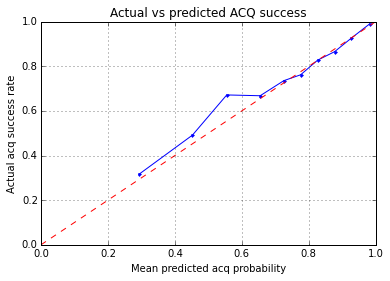

In [14]:
plot_acq_prob_vs_actual();

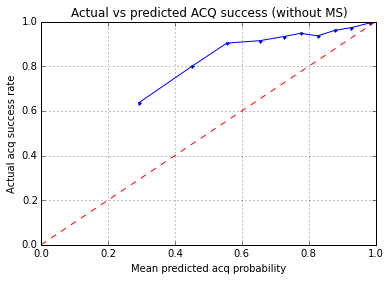

In [15]:
plot_acq_prob_vs_actual(without_ms=True);

## Actual number of stars per obsid vs. expected

*The mean predicted number of acq stars correlates with the actual when MS filtering is removed.*

This demonstrates that there has to be some **clustering** of properties by star field that impact star acquisition success.  That property is now known to be Multiple Stars Suspected (MS) filtering.

Label as **"bad fields"** the obsids where the actual was at least 2 stars less than expected.

In [16]:
def plot_n_expected_per_obsid(without_ms=False):
    n_acqs, n_expected, obsids = get_n_expected(without_ms)
    plt.plot(n_expected, n_acqs + np.random.uniform(-0.1, 0.1, size=len(n_acqs)), '.', alpha=0.5)
    plt.xlim(0, 8.5)
    plt.ylim(0, 8.5)
    plt.grid()
    plt.plot([0,8.5], [0, 8.5], '--r')
    plt.plot([2,8.5], [0, 6.5], '--m')
    plt.xlabel('Predicted acq stars')
    plt.ylabel('Actual acq stars')
    plt.title('Acq stars per obsid');

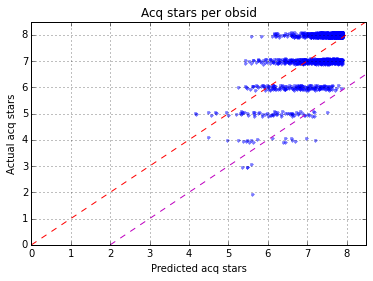

In [17]:
plot_n_expected_per_obsid()

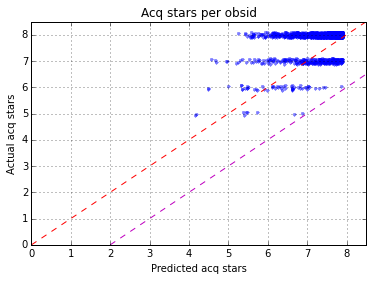

In [18]:
plot_n_expected_per_obsid(without_ms=True)

## Actual number of stars per obsid vs. P(2 or fewer)

In [19]:
def plot_lte_per_obsid(n_lte, without_ms=False):
    n_acqs, n_expected, obsids = get_n_expected(without_ms)
    lte_probs = get_n_or_fewer_expected(n_lte, without_ms)
    plt.semilogx(lte_probs, 
             n_acqs + np.random.uniform(-0.1, 0.1, size=len(n_acqs)), 
             '.', alpha=0.5)
    # plt.xlim(0, 1)
    plt.ylim(0, 8.5)
    plt.grid()
    plt.xlabel('Probability for {} or fewer stars'.format(n_lte))
    plt.ylabel('Actual acq stars')
    plt.title('P({} or fewer stars) vs. N actual acq stars'
             .format(n_lte));
    print('Expected # of {} or fewer: {:.2f}'.format(n_lte, np.sum(lte_probs)))
    print('Actual # of {} or fewer: {:d}'.format(n_lte, np.count_nonzero(n_acqs <= n_lte)))

Expected # of 2 or fewer: 0.34
Actual # of 2 or fewer: 1


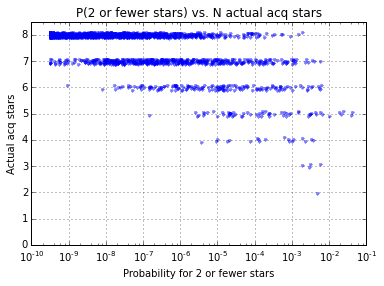

In [20]:
plot_lte_per_obsid(2, without_ms=False)

Expected # of 3 or fewer: 3.67
Actual # of 3 or fewer: 5


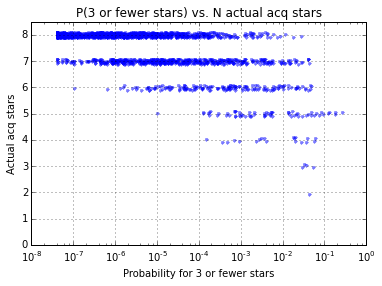

In [21]:
plot_lte_per_obsid(3, without_ms=False)

Expected # of 2 or fewer: 0.34
Actual # of 2 or fewer: 0


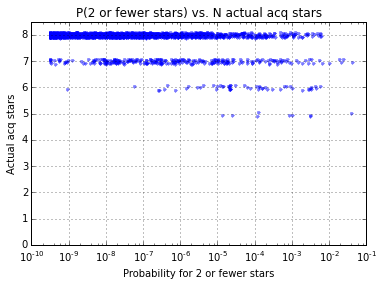

In [22]:
plot_lte_per_obsid(2, without_ms=True)

Expected # of 1 or fewer: 0.02
Actual # of 1 or fewer: 0


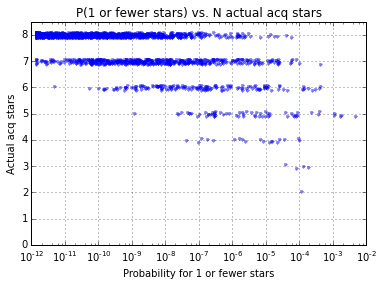

In [23]:
plot_lte_per_obsid(1, without_ms=False)

In [24]:
lte_2_probs = get_n_or_fewer_expected(2, without_ms=False)
n_acqs, n_expected, obsids = get_n_expected(without_ms=False)

In [25]:
ok = lte_2_probs > 0.01
Table([obsids[ok], n_acqs[ok], n_expected[ok], lte_2_probs[ok]],
      names=['obsid', 'n_acq_actual', 'n_expected', 'P(lte2)'])

obsid,n_acq_actual,n_expected,P(lte2)
int64,int64,float64,float64
15662,5,4.54840754791,0.0240487472506
16116,5,4.93608909819,0.0212924052593
16279,5,4.17550531187,0.0386672047219
16998,5,4.69098214123,0.0190188543562
17631,5,4.65137203545,0.0423979520903


In [26]:
import webbrowser

In [27]:
def open_mica(obsid):
    webbrowser.open_new_tab('http://kadi.cfa.harvard.edu/mica/?obsid_or_date={}'.format(obsid))

In [28]:
open_mica(15662)

In [29]:
open_mica(17631)

In [30]:
twos = n_acqs == 2
print(obsids[twos])

obsid
-----
16311


In [31]:
pg.groups[twos]

obsid,obi,acq_start,guide_start,guide_tstart,one_shot_length,revision,slot,idx,type,yang,zang,halfw,mag,acqid,star_tracked,spoiler_tracked,img_func,n_trak_interv,max_trak_cdy,min_trak_cdy,mean_trak_cdy,max_trak_cdz,min_trak_cdz,mean_trak_cdz,max_trak_mag,min_trak_mag,mean_trak_mag,cdy,cdz,dy,dz,ion_rad,def_pix,mult_star,sat_pix,mag_obs,yang_obs,zang_obs,agasc_id,color1,ra,dec,epoch,pm_ra,pm_dec,var,pos_err,mag_aca,mag_err,mag_band,pos_catid,aspq1,aspq2,aspq3,acqq1,acqq2,acqq4,n100_warm_frac,ccd_temp,known_bad,bad_comment,acq_prob,acqid_no_MS
int64,int64,string168,string168,float64,float64,string120,int64,int64,string40,float64,float64,int64,float64,bool,bool,bool,string56,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool,bool,bool,float64,float64,float64,int64,float64,float64,float64,float64,int64,int64,int64,int64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,bool,string120,float64,bool
16311,1,2014:189:23:01:18.760,2014:189:23:01:56.685,521247783.869,8.65972014066,1.0,0,11,ACQ,-1663.0,-1185.0,120,10.154,False,True,False,star,1,0.0976189206281,-0.0153455516715,0.0273427139414,0.163369056117,0.0409271867034,0.105327413125,10.125,10.125,10.125,0.0973136466362,0.0409271867034,10.3021134882,-7.59605033039,False,False,True,False,10.125,-1661.0,-1185.275,331222896,1.47729992867,184.40819781,30.37802718,2000.0,-22,17,-9999,47,10.1535663605,7,4,5,0,0,999,-9999,-9999,-9999,0.160091439733,-14.7281799316,False,,0.695861079607,True
16311,1,2014:189:23:01:18.760,2014:189:23:01:56.685,521247783.869,8.65972014066,1.0,1,12,ACQ,29.0,1703.0,120,10.24,False,True,False,star,1,-1.86381106038,-2.26874320965,-2.08357075709,0.567575702173,0.314041310486,0.417474964164,10.5,10.1875,10.3515625,-2.18039170104,0.420060354217,8.02342523425,-7.21660013528,False,False,True,False,10.3125,29.45,1703.825,260965048,1.49175012112,185.12066739,29.68219928,2000.0,-9999,-18,-9999,48,10.2403354645,6,4,5,0,0,999,-9999,-9999,-9999,0.160091439733,-14.7281799316,False,,0.626839632142,True
16311,1,2014:189:23:01:18.760,2014:189:23:01:56.685,521247783.869,8.65972014066,1.0,2,13,ACQ,-1849.0,675.0,120,10.262,False,True,False,star,1,1.58946152659,1.58891436574,1.58918794617,1.53453311403,1.51735457276,1.52594384339,9.9375,9.9375,9.9375,1.58891436574,1.51735457276,11.793438569,-6.12048311992,False,False,True,False,9.9375,-1845.25,677.35,331354544,1.05995059013,184.99605061,30.26700973,2000.0,-9999,-9999,-9999,42,10.2624740601,5,4,5,0,0,478,127,127,127,0.160091439733,-14.7281799316,False,,0.608061764417,True
16311,1,2014:189:23:01:18.760,2014:189:23:01:56.685,521247783.869,8.65972014066,1.0,3,4,BOT,1992.0,1284.0,120,10.258,False,True,False,star,1,-0.579422132961,-0.877140580925,-0.722012485002,-0.840992309763,-1.20343737046,-1.01234862073,10.1875,10.0,10.1136363636,-0.682325881264,-1.0390603305,9.52123109695,-8.67421350726,False,False,True,False,10.125,1993.9,1282.75,260965416,0.419050037861,184.79842214,29.20037331,2000.0,-44,13,-9999,26,10.2578821182,3,4,5,0,0,999,-9999,-9999,-9999,0.160091439733,-14.7281799316,False,,0.611991700597,True
16311,1,2014:189:23:01:18.760,2014:189:23:01:56.685,521247783.869,8.65972014066,1.0,4,5,BOT,489.0,2016.0,120,10.253,False,True,False,star,1,-1.27671028545,-1.56147330637,-1.37619375966,0.256143801436,-0.127422763304,0.053480588911,10.375,10.25,10.34375,-1.56147330637,0.0501609350822,8.6420315682,-7.58606336112,False,False,True,False,10.375,489.775,2016.075,260966048,0.612849771976,185.16962387,29.533581,2000.0,-30,18,-9999,31,10.2526493073,4,4,5,0,0,999,-9999,253,253,0.160091439733,-14.7281799316,False,,0.61644807734,True
16311,1,2014:189:23:01:18.760,2014:189:23:01:56.685,521247783.869,8.65972014066,1.0,5,6,BOT,-1434.0,-379.0,120,6.46,True,True,False,star,1,0.0558281861479,0.00948898476918,0.0274171221542,0.291480192944,0.222843257894,0.247404921147,6.4375,6.4375,6.4375,0.0292076386118,0.235075657335,10.233893536,-7.40213947118,False,False

In [32]:
threes = n_acqs == 3
print(obsids[threes])

obsid
-----
15756
16620
17322
17632


In [33]:
low_n_exp = n_expected < 4.5
Table([obsids[low_n_exp], n_expected[low_n_exp], n_acqs[low_n_exp]],
      names=['obsid', 'n_expected', 'n_acq_actual'])

obsid,n_expected,n_acq_actual
int64,float64,int64
16105,4.47323183578,5
16279,4.17550531187,5
16374,4.48659391645,4
17378,4.15999796097,5
